## **Loading Libraries**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import time
import re
import random
import os
from os import path
import io
from collections import Counter
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk import RegexpTagger
from nltk import AffixTagger
from nltk import NgramTagger
from nltk import UnigramTagger
from nltk.corpus import brown
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from nltk.corpus import brown
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
from PIL import Image

## **Loading Data**

In [0]:
DV_twitter1 = pd.read_csv("TWITTER1.csv", quotechar='"', header=0, sep=",")
DV_twitter2 = pd.read_csv("TWITTER2.csv", quotechar='"', header=0, sep=",")
DV_twitter3 = pd.read_csv("TWITTER3.csv", quotechar='"', header=0, sep=",")
DV_twitter4 = pd.read_csv("TWITTER4.csv", quotechar='"', header=0, sep=",")
USA_data = pd.read_csv("USA-DATA.csv", quotechar='"', header=0, sep=",")

In [0]:
vertical_stack = pd.concat([DV_twitter1, DV_twitter2,DV_twitter3,DV_twitter4], axis=0,ignore_index=True)


In [0]:
vertical_stack.drop(vertical_stack.loc[vertical_stack['Country']== 'USA'].index, inplace=True)

In [44]:
vertical_stack['Country'].value_counts()[:10]

UK           15834
India         7829
Nigeria       3164
Kenya         2772
Canada        2761
Australia     1416
Uganda        1175
Zimbabwe       844
Pakistan       753
France         675
Name: Country, dtype: int64

In [0]:
vertical_stack = pd.concat([vertical_stack, USA_data], axis=0,ignore_index=True)

In [0]:
Country=vertical_stack[['Country', 'Contents']]

In [47]:
Country['Country'].value_counts()[:10]

UK           15834
USA           9997
India         7829
Nigeria       3164
Kenya         2772
Canada        2761
Australia     1416
Uganda        1175
Zimbabwe       844
Pakistan       753
Name: Country, dtype: int64

In [0]:
#eliminating nulls
Country.dropna(subset = ['Country'],inplace=True)

In [49]:
Country.isnull().sum()

Country     0
Contents    0
dtype: int64

# India TOPIC CONVERSATION


In [50]:
India=Country[Country.Country == 'India']
India

,Country,Contents
37,India,RT @MensDayOutIndia: #KERALA | A rape case has...
48,India,QT @Suresh_Mathew_: RT @ekchidiya_: This round...
60,India,@kavita_krishnan @kunalkamra88 @Nidhi @Shehla_...
153,India,RT @SwamiGeetika: After Disclosing her story o...
169,India,QT @NYMag: Trupm has playboy character and the...
...,...,...
93613,India,RT @Suriya_offl: .@CMamathi & @PCVC2000 truly ...
93621,India,RT @MensDayOutIndia: Domestic Abuse By Female ...
93632,India,RT @antidespondent: Lockdown has become a reas...
93646,India,RT @Aangan_Trust: Victims of #DomesticViolence...


## Pre- Processing Data

In [0]:
# Remove Contractions 
def decontracted(phrase):
    """
    Function uses regular expression to substitute common constructs used in text which 
    involve contractions.
    A contraction is a shortened form of one or two words (one of which is usually a verb).
    e.g. 'won't' will be replaced with 'will not'

    parameters:
    text (str): the text to use
    """ 
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"he\ ’ s", "he is", phrase)
    phrase = re.sub(r"i\ ’ m", "he is", phrase)
   
   

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'didnt", " did not", phrase)
    return phrase

In [0]:
# Reduce words length to avoid misspelling like "happpppy" will be "happy"

def reduce_lengthening(text):
    """
    Function uses regular expression to correct spelling errors from the text which involve incorrect repeated letters

    parameters:
    text (str): the text to use
    """  
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
# Apply the above pre-proessing functions to the Comment column

India['Contents']=India['Contents'].apply(reduce_lengthening, 0) 
India['Contents']=India['Contents'].apply(decontracted, 0)

In [53]:
#Setting Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
stw = sw + ['https','lot','httpstcoxn_tumhy', 'httpstcocgpu_hxya', 're', 'use','good','really','quite','nice','well','little','need','keep','make','important','take','get','very','example','email','facebook','twitter','audiobook','name','box','stay_safe','clip','tag','box','find','pizza','book','smday','list','era''https','lot','httpstcoxn_tumhy', 'httpstcocgpu_hxya', 'win_giveaway']
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def nlpFunction(df):
    """
    Function to carry out NLP type functions on the Comment text.
    
    the text is split into tokens 
    stopwords are removed
    lemmatization is carried out
      e.g.  am, are,is  => be
            car, cars, car's, cars = > car
    the <space> separated words are then added to a new column that will be used for sentiment analysis

    parameters:
    df (dataframe): the dataframe to use, the 'Comment' column is used 
    """ 
    df['com_token'] = df['Contents'].str.lower().str.split()
    df['com_remv'] = df['com_token'].apply(lambda x: [y for y in x if y not in stw]) #tokenization
    df["com_lemma"] = df['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    df["com_tok_str"] = df["com_lemma"].apply(', '.join)
    df["com_full"] = df["com_lemma"].apply(' '.join)
    return df

In [55]:
nltk.download('wordnet')
India = nlpFunction(India)
India["Orig_comment"] = India["Contents"]
India["Comment"] = India["com_full"]
India[['Orig_comment','Comment']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Orig_comment,Comment
37,RT @MensDayOutIndia: #KERALA | A rape case has...,rt @mensdayoutindia: #kerala | rape case regis...
48,QT @Suresh_Mathew_: RT @ekchidiya_: This round...,qt @suresh_mathew_: rt @ekchidiya_: roundtable...
60,@kavita_krishnan @kunalkamra88 @Nidhi @Shehla_...,@kavita_krishnan @kunalkamra88 @nidhi @shehla_...
153,RT @SwamiGeetika: After Disclosing her story o...,rt @swamigeetika: disclosing story nana pateka...
169,QT @NYMag: Trupm has playboy character and the...,qt @nymag: trupm playboy character world know ...


In [56]:
India[['Orig_comment','Comment']].head()

,Orig_comment,Comment
37,RT @MensDayOutIndia: #KERALA | A rape case has...,rt @mensdayoutindia: #kerala | rape case regis...
48,QT @Suresh_Mathew_: RT @ekchidiya_: This round...,qt @suresh_mathew_: rt @ekchidiya_: roundtable...
60,@kavita_krishnan @kunalkamra88 @Nidhi @Shehla_...,@kavita_krishnan @kunalkamra88 @nidhi @shehla_...
153,RT @SwamiGeetika: After Disclosing her story o...,rt @swamigeetika: disclosing story nana pateka...
169,QT @NYMag: Trupm has playboy character and the...,qt @nymag: trupm playboy character world know ...


In [0]:
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
India['Comment']=India['Comment'].apply(lambda x : remove_URL(x))

In [0]:
India['Comment']=India['Comment'].apply(lambda x : remove_punct(x))

In [61]:
India['Comment']

37       rt mensdayoutindia kerala  rape case registere...
48       qt sureshmathew rt ekchidiya roundtable headed...
60       kavitakrishnan kunalkamra88 nidhi shehlarashid...
153      rt swamigeetika disclosing story nana patekar ...
169      qt nymag trupm playboy character world know it...
                               ...                        
93613    rt suriyaoffl cmamathi  pcvc200 truly apprecia...
93621    rt mensdayoutindia domestic abuse female famil...
93632    rt antidespondent lockdown become reason child...
93646    rt aangantrust victim domesticviolence cooped ...
93713    qt harrietgreen1 beautifully written article h...
Name: Comment, Length: 7829, dtype: object

# Topic Modeling-India

In [62]:
pip install pyldavis

In [63]:
pip install gensim

In [64]:
pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
try:
    import re2 as re
except ImportError:
    import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [66]:
# Convert to list
data = India['Comment'].values.tolist()
pprint(data[:20])

['rt mensdayoutindia kerala  rape case registered malayalam film producer '
 'vaishak rajan model ▪️rajan accused allegedly raping ernakulam pretext '
 'offering role film ▪️incident reportedly took place 2017 metoo metooindia '
 'mentoo ',
 'qt sureshmathew rt ekchidiya roundtable headed meghnad bose one biggish name '
 'poppedup metoo wave 2018 against…  rounded anubhavsinha reallyswara '
 'varungrover renukash ghaywan discussion surviving rightwing hindutva '
 'politics bollywood reimagining history bollywood silence around caa nrc dba '
 'representation  more coming soon thequint ',
 'kavitakrishnan kunalkamra88 nidhi shehlarashid umarkhalidjnu metoo movement '
 'sort arnab guys',
 'rt swamigeetika disclosing story nana patekar 10 years tanushree dutta '
 'alleged nanapatekar send high court judge negotiate call police corrupt '
 'giving clean chit sympathy woman metoo cases tanushreedutta ',
 'qt nymag trupm playboy character world know it speaking truth late metoo  “i '
 'made hi

In [67]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['rt', 'mensdayoutindia', 'kerala', 'rape', 'case', 'registered', 'malayalam', 'film', 'producer', 'vaishak', 'rajan', 'model', 'rajan', 'accused', 'allegedly', 'raping', 'ernakulam', 'pretext', 'offering', 'role', 'film', 'incident', 'reportedly', 'took', 'place', 'metoo', 'metooindia', 'mentoo'], ['qt', 'sureshmathew', 'rt', 'ekchidiya', 'roundtable', 'headed', 'meghnad', 'bose', 'one', 'biggish', 'name', 'poppedup', 'metoo', 'wave', 'against', 'rounded', 'anubhavsinha', 'reallyswara', 'varungrover', 'renukash', 'ghaywan', 'discussion', 'surviving', 'rightwing', 'hindutva', 'politics', 'bollywood', 'reimagining', 'history', 'bollywood', 'silence', 'around', 'caa', 'nrc', 'dba', 'representation', 'more', 'coming', 'soon', 'thequint']]


In [68]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['rt', 'advocat', 'mentoo', 'fridaythoughts', 'brexit_trump', 'female', 'predator', 'arrested', 'raping', 'year_old', 'boy', 'metoo', 'remains', 'silent', 'culprit', 'woman', 'many', 'many', 'rape', 'done', 'women', 'crime_gender', 'metoo', 'metoo', 'feminist']


In [0]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stw] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [70]:
#Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:2])

[['rape', 'film', 'place'], ['poppedup', 'hindutva', 'politic', 'history', 'bollywood', 'silence', 'thequint']]


In [71]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(13, 1), (16, 1), (18, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)], [(34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1)], [(23, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1)], [(17, 1), (18, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)]]


In [75]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('film', 1), ('place', 1), ('rape', 1)],
 [('bollywood', 1),
  ('hindutva', 1),
  ('history', 1),
  ('politic', 1),
  ('poppedup', 1),
  ('silence', 1),
  ('thequint', 1)],
 [('arnab', 1), ('guy', 1)],
 [('call', 1),
  ('case', 1),
  ('judge', 1),
  ('police', 1),
  ('story', 1),
  ('sympathy', 1),
  ('woman', 1)],
 [('character', 1),
  ('dressing', 1),
  ('life', 1),
  ('man', 1),
  ('metoo', 1),
  ('president', 1),
  ('world', 1)],
 [('case', 1),
  ('story', 1),
  ('woman', 1),
  ('courage', 1),
  ('firing', 1),
  ('line', 1),
  ('metooliar', 1),
  ('propaganda', 1),
  ('share', 1),
  ('stand', 1),
  ('tanushreedutta', 1)],
 [('economy', 1),
  ('finminindia', 1),
  ('goodtime', 1),
  ('industry', 1),
  ('lawyer', 1),
  ('nation', 1)],
 [('guesthouse', 1), ('sapra', 1)],
 [('metoo', 1),
  ('accuser', 1),
  ('allegation', 1),
  ('epidemic', 1),
  ('item', 1),
  ('molestation', 2),
  ('statute', 1)],
 [('sympathy', 1),
  ('woman', 1),
  ('acquit', 1),
  ('aiiegation', 1),
  ('attentio

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [77]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"case" + 0.084*"law" + 0.061*"gender" + 0.053*"gender_neutral" + '
  '0.049*"number" + 0.048*"biased_law" + 0.048*"rssorg_law" + '
  '0.030*"rsprasad_wil" + 0.026*"people" + 0.019*"genderatworkind"'),
 (1,
  '0.371*"woman" + 0.041*"help" + 0.024*"assistance" + 0.021*"crime" + '
  '0.019*"support" + 0.014*"alert_helplinesupport" + 0.014*"today" + '
  '0.014*"nonsecelebrity" + 0.012*"male" + 0.011*"society"'),
 (2,
  '0.228*"lockdown" + 0.140*"violence" + 0.104*"victim" + 0.048*"सकरम_उसक" + '
  '0.048*"coronafighter" + 0.045*"smritiira_घरल" + 0.018*"pandemic" + '
  '0.015*"lockdown_place" + 0.015*"increase" + 0.014*"survivor"'),
 (3,
  '0.108*"abuse" + 0.093*"domesticabuse" + 0.083*"child" + 0.073*"complaint" + '
  '0.032*"unicef_unhumanright" + 0.027*"dismissed_accused" + 0.023*"pmoindia" '
  '+ 0.022*"still_living" + 0.017*"antidespondent" + 0.017*"family"'),
 (4,
  '0.439*"man" + 0.056*"fakecase" + 0.037*"husband" + 0.036*"wife" + '
  '0.026*"helpline" + 0.025*"makehomes

In [0]:
ldatopics = lda_model.show_topics(formatted=False)

In [79]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.473399834163192

Coherence Score:  0.6175886885231731


# Interpretation of the 8 topics:

The clusters of topics when filtering only on India are diverse:
- 1. The first topic is about gender equality and the laws against domestic violence.
there is a mention of Prasad who is an indian lawyer who recently wrote about male domestic violence act. 
This topic is basically about having sometimes biased laws against domestic violence.
- 2. This topic is about assistance and help and society support.
- 3. The 3rd topic is about the pandemic and lockdown and how it is increasing the problem of DV.
- 4. same as topic 6 they both relate organizations, initiates, and governement actions like UNICEF, ncwindia (National Comittee for Woman), pmoindia (prime minister of india who created a care fun for emergency and distress situations)
- 5. topic 5 relates to topic 1 in the sense that it also focuses on "make home safe for man" as well as woman.  


In [80]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.372934 -0.013491       1        1  22.120283
1     -0.068387  0.238238       2        1  19.865820
2     -0.118435  0.092328       3        1  16.394987
0     -0.035971 -0.042460       4        1  16.090405
5     -0.045444  0.033423       5        1  13.223391
3     -0.104696 -0.308037       6        1  12.305111, topic_info=                 Term         Freq        Total Category  logprob  loglift
22                man  2241.000000  2241.000000  Default  30.0000  30.0000
18              woman  1702.000000  1702.000000  Default  29.0000  29.0000
463          lockdown   863.000000   863.000000  Default  28.0000  28.0000
406          violence   530.000000   530.000000  Default  27.0000  27.0000
143            victim   393.000000   393.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
2092            panic    16.196836    20.168236   Topic6  -5.1657   1.8759
2662    become_reason    15.621431    20.238758   Topic6  -5.2019   1.8362
2562        would_put    13.546338    19.455433   Topic6  -5.3444   1.7331
2560  even_counseling    13.546338    19.455433   Topic6  -5.3444   1.7331
2561   illtreat_woman    13.546338    19.455433   Topic6  -5.3444   1.7331

[236 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2325      2  0.952340    abpnewstv_dna
359       6  0.996990            abuse
858       3  0.984030           abuser
1492      1  0.991362              act
1934      5  0.998354  advyashomatiinc
...     ...       ...              ...
2562      6  0.719593        would_put
2438      1  0.066203            पत_पर
2438      3  0.860639            पत_पर
2074      6  0.973399           रचय_घर
1648      3  0.996303         सकरम_उसक

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 6, 4])

# Saving Visualization-India

In [0]:
pyLDAvis.save_html(vis, 'twitter_topics_India.html')

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

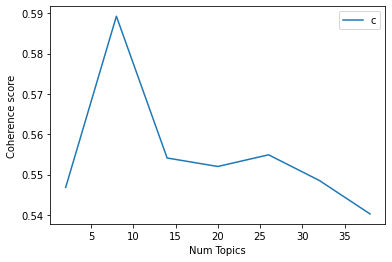

In [84]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5468
Num Topics = 8  has Coherence Value of 0.5893
Num Topics = 14  has Coherence Value of 0.5541
Num Topics = 20  has Coherence Value of 0.552
Num Topics = 26  has Coherence Value of 0.5549
Num Topics = 32  has Coherence Value of 0.5485
Num Topics = 38  has Coherence Value of 0.5402


# UK TOPIC CONVERSATION

In [86]:
UK=Country[(Country.Country.isin(["UK","United Kingdom"]))]
UK

,Country,Contents
67,UK,"RT @Wonderful_U: This is, and will be, the mos..."
70,UK,RT @OnTheRecordDoc: “Heading to the premiere f...
74,UK,RT @wewritelettrs: i decided to write about ho...
81,UK,QT @joaoinghana: RT @ggbrokensilence: It's a s...
96,UK,QT @mbalter: RT @Help4StudentsUK: It seems tha...
...,...,...
93701,UK,RT @AasmaDay: Abusive men are using coronaviru...
93702,UK,RT @LeicsCountyHall: Self-isolation for those ...
93709,UK,RT @meggwriight: if you are experiencing domes...
93714,UK,RT @SolaceWomensAid: We know many services are...


# Pre- Processing Data

In [0]:
# Apply the above pre-proessing functions to the Comment column

UK['Contents']=UK['Contents'].apply(reduce_lengthening, 0) 
UK['Contents']=UK['Contents'].apply(decontracted, 0)

In [88]:
#Setting Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
stw = sw + ['http,''https','lot','httpstcoxn_tumhy', 'httpstco_ldhjnrnha','httpstcofmttps','httpstcocgpu_hxya', 'httpstco','trainings','re', 'use','good','really','quite','nice','well','little','need','keep','make','important','take','get','very','example']
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
nltk.download('wordnet')
UK = nlpFunction(UK)
UK["Orig_comment"] = UK["Contents"]
UK["Comment"] = UK["com_full"]
UK[['Orig_comment','Comment']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Orig_comment,Comment
67,"RT @Wonderful_U: This is, and will be, the mos...","rt @wonderful_u: is, be, personal post i‘ll ev..."
70,RT @OnTheRecordDoc: “Heading to the premiere f...,rt @ontherecorddoc: “heading premiere filled w...
74,RT @wewritelettrs: i decided to write about ho...,rt @wewritelettrs: decided write broadway wide...
81,QT @joaoinghana: RT @ggbrokensilence: It is a ...,qt @joaoinghana: rt @ggbrokensilence: shame cy...
96,QT @mbalter: RT @Help4StudentsUK: It seems tha...,qt @mbalter: rt @help4studentsuk: seems many l...


In [0]:
UK['Comment']=UK['Comment'].apply(lambda x : remove_punct(x))
UK['Comment']=UK['Comment'].apply(lambda x : remove_URL(x))

# TOPIC MODELING UK

In [91]:
# Convert to list
data = UK['Comment'].values.tolist()
pprint(data[:20])

['rt wonderfulu is be personal post i‘ll ever share metoo httpstcodgbxyjheix '
 'photography alexcameron httpstcom5dkvnn4hg',
 'rt ontherecorddoc “heading premiere filled w anxiety  tremendous gratitude '
 'i’m grateful courage sisterhood fellow survivors hope victim sexual '
 'harassment  violence feel affirmed movie  know alone” deardrewdixon metoo',
 'rt wewritelettrs decided write broadway wider theatre industry managed evade '
 'consequence metoo movement thus far much need done support survivor within '
 'community httpstcot23oopwaiu',
 'qt joaoinghana rt ggbrokensilence shame cyprus live reputation ideal '
 'romantic getaway far shameful they…  httpstcow6zn0vzvkh',
 'qt mbalter rt help4studentsuk seems many lawyer understand risk denying '
 'obfuscating covering etc protect uni it…  one reason academic institution '
 'handle metoo bullying case badly follow advice lawyer hired specifically '
 'protect institution student victims academic justify negligence saying',
 'qt cnbc rt 

In [92]:
data_words = list(sent_to_words(data))

print(data_words[:2])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

[['rt', 'wonderfulu', 'is', 'be', 'personal', 'post', 'll', 'ever', 'share', 'metoo', 'photography', 'alexcameron', 'httpstcom', 'dkvnn', 'hg'], ['rt', 'ontherecorddoc', 'heading', 'premiere', 'filled', 'anxiety', 'tremendous', 'gratitude', 'grateful', 'courage', 'sisterhood', 'fellow', 'survivors', 'hope', 'victim', 'sexual', 'harassment', 'violence', 'feel', 'affirmed', 'movie', 'know', 'alone', 'deardrewdixon', 'metoo']]
['qt', 'madblack', 'done', 'madeleine', 'powerful', 'gift', 'offer', 'helping', 'others', 'find', 'voice', 'know', 'already', 'you_ve', 'helped', 'tedx', 'audience', 'tedxglasgow', 'talk', 'available', 'please_watch', 'rt', 'speaking', 'cant', 'find', 'voice', 'yet', 'tedtalks', 'unbroken', 'speaking', 'unspeakable', 'tedxgla', 'tedxtalks', 'madtalks', 'metoo', 'findyourvoice', 'endthesilence', 'unbroken', 'httpstco', 'evdnz', 'iny']


In [93]:
 #Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:2])

[['post'], ['anxiety', 'courage', 'sisterhood', 'fellow', 'survivor', 'harassment', 'violence', 'movie']]


In [94]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(7, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1)], [(15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2)], [(12, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2)], [(29, 1), (41, 1), (42, 1)], [(24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2)], [(18, 1), (29, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


In [95]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('post', 1)],
 [('anxiety', 1),
  ('courage', 1),
  ('fellow', 1),
  ('harassment', 1),
  ('movie', 1),
  ('sisterhood', 1),
  ('survivor', 1),
  ('violence', 1)],
 [('survivor', 1),
  ('community', 1),
  ('consequence', 1),
  ('industry', 1),
  ('support', 1)],
 [('getaway', 1), ('reputation', 1)],
 [('advice', 1),
  ('case', 1),
  ('institution', 2),
  ('lawyer', 2),
  ('negligence', 1),
  ('reason', 1),
  ('risk', 1),
  ('student', 1),
  ('victim', 1)],
 [('afraid_hire', 1),
  ('century', 1),
  ('httpstcocti', 1),
  ('kjfrbd', 1),
  ('man', 2),
  ('woman', 2)],
 [('support', 1),
  ('woman', 1),
  ('avoid', 1),
  ('background', 1),
  ('bos', 1),
  ('chance', 1),
  ('employee', 1),
  ('feom', 1),
  ('folk', 1),
  ('issue', 1),
  ('metoo', 1),
  ('story', 1),
  ('way', 2)],
 [('woman', 1), ('citizen', 1), ('country', 1)],
 [('afraid_hire', 1),
  ('century', 1),
  ('httpstcocti', 1),
  ('kjfrbd', 1),
  ('man', 2),
  ('woman', 2)],
 [('lawyer', 1),
  ('woman', 1),
  ('client', 1),
  ('

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [97]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.432*"domesticabuse" + 0.060*"police" + 0.043*"service" + '
  '0.039*"ldhjnrnha" + 0.021*"lockdown_commander" + 0.021*"survivor" + '
  '0.013*"emergency_order" + 0.013*"secure_way" + 0.013*"night_day" + '
  '0.012*"today"'),
 (1,
  '0.120*"help" + 0.062*"woman" + 0.059*"lockdown" + 0.044*"danger" + '
  '0.044*"work" + 0.034*"time" + 0.028*"case" + 0.023*"support_victimsurvivor" '
  '+ 0.023*"complex_housing" + 0.022*"report"'),
 (2,
  '0.034*"response" + 0.033*"child" + 0.024*"reveal_man" + '
  '0.024*"killing_woman" + 0.024*"httpstcosz_fdyfk" + 0.024*"almost_one" + '
  '0.023*"pandemic" + 0.019*"campaign" + 0.018*"contact" + 0.015*"charity"'),
 (3,
  '0.209*"support" + 0.145*"domestic_abuse" + 0.101*"response_support" + '
  '0.046*"call" + 0.040*"call_immediate" + 0.023*"advice" + 0.019*"community" '
  '+ 0.019*"increase" + 0.017*"mgszof_th" + 0.010*"thank"'),
 (4,
  '0.095*"support_service" + 0.066*"remain_available" + 0.043*"helpline" + '
  '0.043*"people" + 0.033*"apply_po

In [0]:
ldatopics = lda_model.show_topics(formatted=False)

In [99]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.8042412723333925

Coherence Score:  0.5255876158060669


# Interpretation of the 8 topics:

UK topic are not only about organizations, but the topics revolve around mainly domestic abuse, trying to aid women, in the second topic inviting women to call immediately during COVID. 


- 1. This topic is about the lockdown and emergency order by police . 
- 2. Covid help: Aiding women to call during the actual crisis and trying to aid women. 
- 3. Charities 
- 4. community support and sharing stories of victims.
- 5. Aid during COVID promoting a helpline and communicating that support service remains availiable.
- 6. Same as topic 1 and 2
 

In [100]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.257093 -0.253734       1        1  23.825159
1      0.017433  0.157365       2        1  20.032396
3     -0.305920 -0.195133       3        1  19.355366
5      0.020781  0.079238       4        1  15.459956
4     -0.003023  0.104813       5        1  13.278407
2      0.013634  0.107451       6        1   8.048725, topic_info=                    Term         Freq        Total Category  logprob  loglift
523        domesticabuse  7195.000000  7195.000000  Default  30.0000  30.0000
12               support  2828.000000  2828.000000  Default  29.0000  29.0000
23                victim  2077.000000  2077.000000  Default  28.0000  28.0000
386       domestic_abuse  1964.000000  1964.000000  Default  27.0000  27.0000
193                 help  1680.000000  1680.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
5163  support_unsettling    41.541908    42.922947   Topic6  -4.9074   2.4870
5161          feel_alone    41.541908    42.922947   Topic6  -4.9074   2.4870
5162  infouavaorguk_call    41.541908    42.922947   Topic6  -4.9074   2.4870
6623      watchthisspace    76.206314   113.020325   Topic6  -4.3007   2.1255
6622  daha_accreditation    76.206314   113.020325   Topic6  -4.3007   2.1255

[237 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
115       4  0.999185           abuse
478       5  0.993899          abuser
2190      6  0.969784     abusive_man
648       3  0.994461          access
4479      4  0.983991       addiction
...     ...       ...             ...
741       2  0.995845          worker
4172      3  0.973299      worker_hrs
3274      6  0.990283         xxqsdnl
223       5  0.984439            year
2306      2  0.998104  youarenotalone

[277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 5, 3])

In [0]:
pyLDAvis.save_html(vis, 'twitter_topics_UK.html')

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

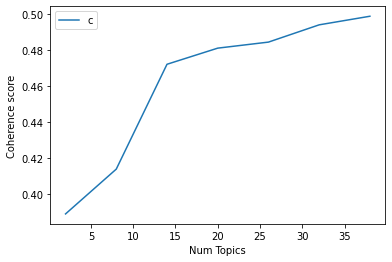

In [104]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [105]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3891
Num Topics = 8  has Coherence Value of 0.4139
Num Topics = 14  has Coherence Value of 0.4721
Num Topics = 20  has Coherence Value of 0.481
Num Topics = 26  has Coherence Value of 0.4844
Num Topics = 32  has Coherence Value of 0.4939
Num Topics = 38  has Coherence Value of 0.4987


# USA TOPIC CONVERSATION

In [106]:
USA = Country[(Country.Country.isin(["USA"]))]

USA

,Country,Contents
93718,USA,@matthewamiller #MeToo meant nothing at all. h...
93719,USA,@Alyssa_Milano Where is you #metoo with young ...
93720,USA,QT @sylvana46755345: RT @JeffreeStar: This is ...
93721,USA,RT @JoeTalkShow: it's actually disgusting to s...
93722,USA,"RT @ShannonDingle: “If true, why didn’t this c..."
...,...,...
103713,USA,"#MeToo movement = #BelieveAllWomen, evidence o..."
103714,USA,@cspan It’s over for this fake a$$ #MeToo move...
103715,USA,QT @sylvana46755345: RT @JeffreeStar: This is ...
103716,USA,"RT @TheRealDuckBert: The Talk - ""@adamlambert ..."


In [0]:
USA['Contents']=USA['Contents'].apply(reduce_lengthening, 0) 
USA['Contents']=USA['Contents'].apply(decontracted, 0)

In [108]:
nltk.download('wordnet')
USA = nlpFunction(USA)
USA["Orig_comment"] = USA["Contents"]
USA["Comment"] = USA["com_full"]
USA[['Orig_comment','Comment']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Orig_comment,Comment
93718,@matthewamiller #MeToo meant nothing at all. h...,@matthewamiller #metoo meant nothing all. http...
93719,@Alyssa_Milano Where is you #metoo with young ...,@alyssa_milano #metoo young lady @joebiden got...
93720,QT @sylvana46755345: RT @JeffreeStar: This is ...,qt @sylvana46755345: rt @jeffreestar: iconic!!...
93721,RT @JoeTalkShow: it is actually disgusting to ...,rt @joetalkshow: actually disgusting see many ...
93722,"RT @ShannonDingle: “If true, why didn’t this c...","rt @shannondingle: “if true, didn’t come runni..."


In [109]:
USA[['Orig_comment','Comment']].head()

,Orig_comment,Comment
93718,@matthewamiller #MeToo meant nothing at all. h...,@matthewamiller #metoo meant nothing all. http...
93719,@Alyssa_Milano Where is you #metoo with young ...,@alyssa_milano #metoo young lady @joebiden got...
93720,QT @sylvana46755345: RT @JeffreeStar: This is ...,qt @sylvana46755345: rt @jeffreestar: iconic!!...
93721,RT @JoeTalkShow: it is actually disgusting to ...,rt @joetalkshow: actually disgusting see many ...
93722,"RT @ShannonDingle: “If true, why didn’t this c...","rt @shannondingle: “if true, didn’t come runni..."


In [110]:
USA['Comment']=USA['Comment'].apply(lambda x : remove_URL(x))
USA['Comment']=USA['Comment'].apply(lambda x : remove_punct(x))
USA['Comment']

93718               matthewamiller metoo meant nothing all 
93719     alyssamilano metoo young lady joebiden got tou...
93720     qt sylvana46755345 rt jeffreestar iconic omg a...
93721     rt joetalkshow actually disgusting see many wo...
93722     rt shannondingle “if true didn’t come running ...
                                ...                        
103713    metoo movement  believeallwomen evidence optio...
103714                     cspan it’s fake a metoo movement
103715    qt sylvana46755345 rt jeffreestar iconic omg a...
103716    rt therealduckbert talk  adamlambert hope velv...
103717    rt liquidlaugh nancy hillary karmella oprha mi...
Name: Comment, Length: 9997, dtype: object

# Topic Modeling-USA

In [111]:
# Convert to list
data_USA = USA['Comment'].values.tolist()
pprint(data_USA[:20])

['matthewamiller metoo meant nothing all ',
 'alyssamilano metoo young lady joebiden got touchyfeeling with word nasty azz '
 'mouth closed oh must democrat party smh',
 'qt sylvana46755345 rt jeffreestar iconic omg amazing tattoo 😭😭  finaly here '
 'thank jeffreestar hand say jeffreestarapproved conspiracy '
 'jeffreestarapproved handtattoo love staysafe ',
 'rt joetalkshow actually disgusting see many woman left rallying around '
 'joebiden face tarareade accusations simply show metoo movement believing '
 'woman all stopping scotus nominee period make sick',
 'rt shannondingle “if true didn’t come running vp” understand question y’all '
 'understand context metoo outrage brock turner many brave woman since used '
 'voice help u find own',
 'zazzle sale 15 custom shower curtain curtains  eiffeltower crown tiara music '
 'sheetmusic horse art colors tulips imagine homedecor code thurzdaydeal end '
 'apr30 2020 staysafe stayhome stayathome stayhomesaveslives togetherathome',
 'rt katri

In [112]:
data_words_USA = list(sent_to_words(data_USA))

print(data_words_USA[:2])

[['matthewamiller', 'metoo', 'meant', 'nothing', 'all'], ['alyssamilano', 'metoo', 'young', 'lady', 'joebiden', 'got', 'touchyfeeling', 'with', 'word', 'nasty', 'azz', 'mouth', 'closed', 'oh', 'must', 'democrat', 'party', 'smh']]


In [113]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_USA, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_USA], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words_USA[10]]])

['susannalharris', 'woman', 'block', 'pointing', 'metoo', 'woman', 'hired', 'look', 'which', 'also', 'discrimination', 'badge', 'honor', 'now', 'got_it', 'sexwork']


In [114]:
#Remove Stop Words
data_words_nostops = remove_stopwords(data_words_USA)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:20])

[[], ['lady', 'word', 'mouth'], [], ['woman', 'show'], ['question', 'find'], ['custom', 'shower', 'curtain', 'tiara', 'music', 'sheetmusic', 'horse', 'art', 'color'], [], ['metoo'], ['today', 'announcement', 'helpingother'], ['believewoman'], ['woman', 'woman', 'discrimination', 'honor', 'sexwork'], ['hypocrite'], ['man', 'step'], ['story', 'metoo'], ['woman', 'show'], ['team', 'alonetogether'], ['family'], ['situation'], ['dealing_instead', 'open_independent', 'president'], ['science_face', 'staysafe_style', 'believe_access', 'cost_please', 'sciart_academictwitter']]


In [115]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[], [(0, 1), (1, 1), (2, 1)], [], [(3, 1), (4, 1)], [(5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [], [(16, 1)], [(17, 1), (18, 1), (19, 1)], [(20, 1)]]


In [116]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[],
 [('lady', 1), ('mouth', 1), ('word', 1)],
 [],
 [('show', 1), ('woman', 1)],
 [('find', 1), ('question', 1)],
 [('art', 1),
  ('color', 1),
  ('curtain', 1),
  ('custom', 1),
  ('horse', 1),
  ('music', 1),
  ('sheetmusic', 1),
  ('shower', 1),
  ('tiara', 1)],
 [],
 [('metoo', 1)],
 [('announcement', 1), ('helpingother', 1), ('today', 1)],
 [('believewoman', 1)]]

In [0]:
lda_model_USA = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [118]:
pprint(lda_model_USA.print_topics())
doc_lda = lda_model_USA[corpus]

[(0,
  '0.064*"hypocrite" + 0.042*"story" + 0.025*"campaign" + 0.024*"opponent" + '
  '0.024*"staysafe" + 0.020*"analysis_say" + 0.020*"based_joebiden" + '
  '0.020*"michaeljstern" + 0.020*"way" + 0.019*"tarareade"'),
 (1,
  '0.129*"appalling" + 0.087*"woman" + 0.039*"people" + 0.031*"support" + '
  '0.013*"rape" + 0.013*"survivor" + 0.011*"help" + 0.011*"everything_politic" '
  '+ 0.011*"work" + 0.009*"truth"'),
 (2,
  '0.135*"metoo" + 0.043*"metoo_movement" + 0.037*"hypocrisy" + '
  '0.030*"tara_reade" + 0.019*"victim" + 0.017*"today" + 0.017*"posts_metoo" + '
  '0.016*"firechrishaye" + 0.012*"feeling" + 0.011*"election"'),
 (3,
  '0.045*"movement" + 0.036*"fwiw_would" + 0.036*"still_despicable" + '
  '0.030*"allegation" + 0.024*"reade" + 0.022*"part" + '
  '0.018*"emphasize_enough" + 0.018*"th_ca" + 0.018*"claim" + 0.014*"issue"'),
 (4,
  '0.091*"situation" + 0.057*"officially_sworn" + 0.057*"felt_one" + '
  '0.057*"delaware_joe" + 0.055*"rite_passage" + 0.050*"gropey_joe" + '
  '0.

In [0]:
ldatopics = lda_model_USA.show_topics(formatted=False)

In [120]:
#Compute Perplexity
print('\nPerplexity: ', lda_model_USA.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_USA = CoherenceModel(model=lda_model_USA, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_USA.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.501235645261806

Coherence Score:  0.5884708289599642


# Interpretation of the 8 topics:

- US Is the News country, where is more about the actual sharing of news and the story of the movement. With Joe Biden recent abuse scandal, the first 5 topics revolve around it, also there is a mention of "Alyssa Milano" American Actress that started the "metoo movement" and is in support of Biden.

- The only "Corona Lockdown mention" is "Covid" and #Stayathome, but there is no communication towards women or stories baout women in any of the hashtags, the only identified movement is #metoo and #believing_woman but realted to Joe Biden and Senator Tara.

In [121]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_USA, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.086616 -0.223722       1        1  19.638044
2     -0.058748 -0.061493       2        1  19.086296
0     -0.058461  0.241535       3        1  17.877922
4      0.350326 -0.019269       4        1  15.973351
5     -0.060140  0.126495       5        1  13.860241
3     -0.086361 -0.063546       6        1  13.564138, topic_info=                      Term        Freq       Total Category  logprob  loglift
16                   metoo  707.000000  707.000000  Default  30.0000  30.0000
40               appalling  696.000000  696.000000  Default  29.0000  29.0000
4                    woman  471.000000  471.000000  Default  28.0000  28.0000
31               situation  399.000000  399.000000  Default  27.0000  27.0000
24               hypocrite  314.000000  314.000000  Default  26.0000  26.0000
...                    ...         ...         ...      ...      ...      ...
2395                  spin   24.045387   24.733089   Topic6  -5.0415   1.9695
217                 rapist   22.014044   22.707981   Topic6  -5.1298   1.9667
3140  transforming_culture   19.769461   20.456825   Topic6  -5.2373   1.9636
3138         actually_care   19.769461   20.456825   Topic6  -5.2373   1.9636
2394           network_try   19.516750   20.203537   Topic6  -5.2502   1.9632

[219 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
108       1  0.977224          abuse
252       4  0.994200     accusation
3138      6  0.977669  actually_care
258       6  0.996087     allegation
156       3  0.997044   analysis_say
...     ...       ...            ...
2         1  0.992249           word
402       1  0.983784           work
5061      5  0.893971  workingnation
5061      6  0.095783  workingnation
320       6  0.962613           year

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 6, 4])

# Saving Visualization-USA

In [0]:
pyLDAvis.save_html(vis, 'twitter_topics_USA.html')

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

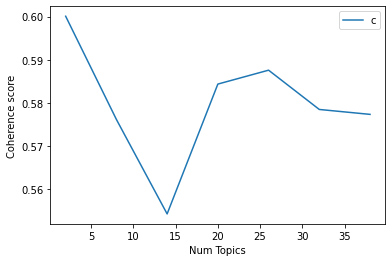

In [124]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6001
Num Topics = 8  has Coherence Value of 0.5761
Num Topics = 14  has Coherence Value of 0.5542
Num Topics = 20  has Coherence Value of 0.5843
Num Topics = 26  has Coherence Value of 0.5876
Num Topics = 32  has Coherence Value of 0.5785
Num Topics = 38  has Coherence Value of 0.5773


# Kenya TOPIC CONVERSATION

In [126]:
Kenya = Country[(Country.Country.isin(["Kenya"]))]

Kenya

,Country,Contents
746,Kenya,RT @UN_Women: For a world where nobody has to ...
1465,Kenya,RT @DonaldBKipkorir: The #MeToo Movement ended...
2290,Kenya,QT @NetworkAthena: RT @Zamara_fdn: Hashtags to...
2293,Kenya,QT @NetworkAthena: Hashtags to follow and comm...
2303,Kenya,RT @UN_Women: #MeToo #TimesUp #NiUnaMenos #HeF...
...,...,...
92043,Kenya,Police in Kirinyaga County are holding a 34-ye...
92111,Kenya,RT @DjDaboTrabo: 218 number of reported cases ...
92165,Kenya,RT @DjDaboTrabo: 218 number of reported cases ...
92167,Kenya,RT @DjDaboTrabo: 218 number of reported cases ...


In [0]:
Kenya['Contents']=Kenya['Contents'].apply(reduce_lengthening, 0) 
Kenya['Contents']=Kenya['Contents'].apply(decontracted, 0)

In [128]:
nltk.download('wordnet')
Kenya = nlpFunction(Kenya)
Kenya["Orig_comment"] = Kenya["Contents"]
Kenya["Comment"] = Kenya["com_full"]
Kenya[['Orig_comment','Comment']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Orig_comment,Comment
746,RT @UN_Women: For a world where nobody has to ...,"rt @un_women: world nobody say #metoo anymore,..."
1465,RT @DonaldBKipkorir: The #MeToo Movement ended...,rt @donaldbkipkorir: #metoo movement ended age...
2290,QT @NetworkAthena: RT @Zamara_fdn: Hashtags to...,qt @networkathena: rt @zamara_fdn: hashtags fo...
2293,QT @NetworkAthena: Hashtags to follow and comm...,qt @networkathena: hashtags follow comment #iw...
2303,RT @UN_Women: #MeToo #TimesUp #NiUnaMenos #HeF...,rt @un_women: #metoo #timesup #niunamenos #hef...


In [129]:
Kenya[['Orig_comment','Comment']].head()

,Orig_comment,Comment
746,RT @UN_Women: For a world where nobody has to ...,"rt @un_women: world nobody say #metoo anymore,..."
1465,RT @DonaldBKipkorir: The #MeToo Movement ended...,rt @donaldbkipkorir: #metoo movement ended age...
2290,QT @NetworkAthena: RT @Zamara_fdn: Hashtags to...,qt @networkathena: rt @zamara_fdn: hashtags fo...
2293,QT @NetworkAthena: Hashtags to follow and comm...,qt @networkathena: hashtags follow comment #iw...
2303,RT @UN_Women: #MeToo #TimesUp #NiUnaMenos #HeF...,rt @un_women: #metoo #timesup #niunamenos #hef...


In [130]:
Kenya['Comment']=Kenya['Comment'].apply(lambda x : remove_URL(x))
Kenya['Comment']=Kenya['Comment'].apply(lambda x : remove_punct(x))
Kenya['Comment']

746      rt unwomen world nobody say metoo anymore let ...
1465     rt donaldbkipkorir metoo movement ended age se...
2290     qt networkathena rt zamarafdn hashtags follow ...
2293     qt networkathena hashtags follow comment iwill...
2303     rt unwomen metoo timesup niunamenos heforshe o...
                               ...                        
92043    police kirinyaga county holding 34yearold man ...
92111    rt djdabotrabo 218 number reported case report...
92165    rt djdabotrabo 218 number reported case report...
92167    rt djdabotrabo 218 number reported case report...
92168    218 number reported case reported far increase...
Name: Comment, Length: 2772, dtype: object

# Topic Modeling-Kenya

In [131]:
# Convert to list
data_Kenya = Kenya['Comment'].values.tolist()
pprint(data_Kenya[:20])

['rt unwomen world nobody say metoo anymore let break silence hold perpetrator '
 'accountable orangetheworld 16days ',
 'rt donaldbkipkorir metoo movement ended age seduction  chivalry  aid '
 'dampened romance  coronavirus ushering end personal human interraction  '
 'start truly digital age human interraction  end human civilization leading '
 'rapture yawm alqiyamah',
 'qt networkathena rt zamarafdn hashtags follow comment iwillgoout whyistayed '
 'yesallwomen womenshould womenrights genderinkenya unwomenafrica…  hashtag '
 'womensrights 12 social medium movement follow 14 addition whatgirlswant  '
 'whatwomenwant unwomen unaids etcrone genderequity4a1 catherinenyamb1 cnsozi ',
 'qt networkathena hashtags follow comment iwillgoout whyistayed yesallwomen '
 'womenshould womenrights genderinkenya unwomenafrica kenyasrhr rhrnkenya  '
 'hashtag womensrights 12 social medium movement follow 14 addition '
 'whatgirlswant  whatwomenwant unwomen unaids etcrone genderequity4a1 '
 'catherine

In [132]:
data_words_Kenya = list(sent_to_words(data_Kenya))

print(data_words_Kenya[:2])

[['rt', 'unwomen', 'world', 'nobody', 'say', 'metoo', 'anymore', 'let', 'break', 'silence', 'hold', 'perpetrator', 'accountable', 'orangetheworld', 'days'], ['rt', 'donaldbkipkorir', 'metoo', 'movement', 'ended', 'age', 'seduction', 'chivalry', 'aid', 'dampened', 'romance', 'coronavirus', 'ushering', 'end', 'personal', 'human', 'interraction', 'start', 'truly', 'digital', 'age', 'human', 'interraction', 'end', 'human', 'civilization', 'leading', 'rapture', 'yawm', 'alqiyamah']]


In [133]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_Kenya, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_Kenya], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words_Kenya[10]]])

['rt_unwomen_metoo', 'timesup_niunamenos_heforshe_orangetheworld', 'everydaysexism_womenshould_yesallwomen_whyistayed', 'iwillgoout_social_medium_become', 'new_frontier_join_fight', 'equality_justice']


In [134]:
#Remove Stop Words
data_words_nostops = remove_stopwords(data_words_Kenya)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:20])

[['metoo', 'perpetrator', 'day'], ['age', 'seduction', 'aid', 'romance', 'interraction', 'age', 'interraction', 'civilization', 'rapture'], ['comment', 'iwillgoout', 'movement', 'addition', 'unaid', 'cnsozi'], ['comment', 'iwillgoout', 'movement', 'addition', 'unaid', 'cnsozi'], [], [], [], [], [], [], [], ['story', 'heforher', 'iwillgoout', 'endchildabuse', 'mystory', 'africanunion'], ['story', 'heforher', 'iwillgoout'], ['see', 'violence', 'investment', 'isulecture', 'domesticabuse'], ['covid', 'like_france', 'violence', 'withher'], ['violence', 'woman', 'withher'], ['woman'], [], ['woman'], ['covid', 'like_france', 'violence', 'withher']]


In [135]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1)], [(3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [], [], [], [], [], []]


In [136]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('day', 1), ('metoo', 1), ('perpetrator', 1)],
 [('age', 2),
  ('aid', 1),
  ('civilization', 1),
  ('interraction', 2),
  ('rapture', 1),
  ('romance', 1),
  ('seduction', 1)],
 [('addition', 1),
  ('cnsozi', 1),
  ('comment', 1),
  ('iwillgoout', 1),
  ('movement', 1),
  ('unaid', 1)],
 [('addition', 1),
  ('cnsozi', 1),
  ('comment', 1),
  ('iwillgoout', 1),
  ('movement', 1),
  ('unaid', 1)],
 [],
 [],
 [],
 [],
 [],
 []]

In [0]:
lda_model_Kenya = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [138]:
pprint(lda_model_Kenya.print_topics())
doc_lda = lda_model_Kenya[corpus]

[(0,
  '0.056*"gender" + 0.030*"help" + 0.024*"home" + 0.023*"talk" + '
  '0.020*"health" + 0.017*"importance" + 0.015*"genderequality" + '
  '0.015*"lockdown" + 0.013*"domestic_abuse" + 0.012*"tomorrow"'),
 (1,
  '0.093*"girl" + 0.046*"unwoman" + 0.045*"support" + 0.026*"access" + '
  '0.025*"right" + 0.021*"opportunity" + 0.020*"review" + 0.018*"year" + '
  '0.016*"life" + 0.016*"friend"'),
 (2,
  '0.054*"work" + 0.030*"victim" + 0.019*"domesticabuse" + 0.019*"day" + '
  '0.017*"education" + 0.015*"marywthuo_azmairat" + '
  '0.015*"nfnvorg_villarosakempin" + 0.015*"husband" + 0.014*"demand" + '
  '0.014*"experience"'),
 (3,
  '0.092*"violence" + 0.087*"withher" + 0.026*"child" + 0.025*"domesticabuse" '
  '+ 0.022*"school" + 0.013*"covid" + 0.013*"eachforequal" + 0.013*"role" + '
  '0.012*"action" + 0.011*"pandemic"'),
 (4,
  '0.202*"woman" + 0.039*"time" + 0.032*"man" + 0.024*"equality" + '
  '0.023*"world" + 0.022*"people" + 0.016*"gender_equality" + 0.016*"iwd" + '
  '0.015*"commun

In [0]:
ldatopics = lda_model_Kenya.show_topics(formatted=False)

In [141]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_Kenya.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_Kenya = CoherenceModel(model=lda_model_Kenya, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_Kenya.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.185521203376155

Coherence Score:  0.5815639791263937


# Interpretation of the 8 topics:

Topics clustered from filtering on Kenya are oriented towards gender based violence and gender equality, and also initiates related to DV:
- 1. This topic is about gender equality in the case of domestic violence.
- 2. 2nd topic is about UNWoman organiation and support to domestic violence victims.
- 3. This topics is about the domestic abuse and education 
- 4. This is about initiatives related to DV like withher that talks about creating a world where woman and girls are safe, and also eachforequal movement that was created in international woman day 2020.
- 5. same as topic 6 it is about GBV(gender based violence) by the United Nations Population Fund (UNFPA) which is something Kenya has reently been shinning a light on.

In [142]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_Kenya, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.352680 -0.061712       1        1  26.649990
3     -0.024271  0.223373       2        1  19.484718
1     -0.122439 -0.279246       3        1  15.960320
0     -0.081259  0.023783       4        1  13.707885
5     -0.074183  0.014057       5        1  13.410953
2     -0.050529  0.079745       6        1  10.786123, topic_info=               Term        Freq       Total Category  logprob  loglift
29            woman  541.000000  541.000000  Default  30.0000  30.0000
25         violence  178.000000  178.000000  Default  29.0000  29.0000
28          withher  169.000000  169.000000  Default  28.0000  28.0000
82             girl  148.000000  148.000000  Default  27.0000  27.0000
171          gender   76.000000   76.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1792           tune    7.966681    8.753701   Topic6  -4.9009   2.1327
1102        culture    6.635123    7.310657   Topic6  -5.0838   2.1300
21    domesticabuse   20.078531   68.952591   Topic6  -3.9766   0.9931
178      leadership   13.332126   32.277283   Topic6  -4.3860   1.3427
1770         indoor    7.006699    8.924259   Topic6  -5.0293   1.9850

[230 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
44        5  0.984518                 abuse
1622      6  0.908176  abuse_discrimination
66        6  0.926678                abuser
255       3  0.981166                access
31        2  0.993769                action
...     ...       ...                   ...
332       1  0.991669                 world
1603      4  0.964454  yalirlcea_korieunfpa
323       3  0.982652                  year
1852      2  0.951788           yearold_man
145       4  0.923973                 youth

[209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 6, 3])

# Saving Visualization-Kenya

In [0]:
pyLDAvis.save_html(vis, 'twitter_topics_Kenya.html')

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

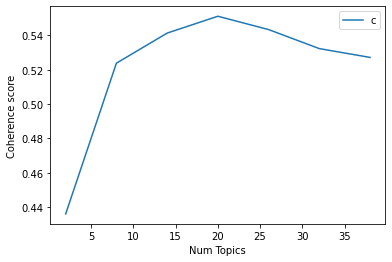

In [145]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [146]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4361
Num Topics = 8  has Coherence Value of 0.5238
Num Topics = 14  has Coherence Value of 0.5413
Num Topics = 20  has Coherence Value of 0.5511
Num Topics = 26  has Coherence Value of 0.5434
Num Topics = 32  has Coherence Value of 0.5323
Num Topics = 38  has Coherence Value of 0.5272


# Nigeria TOPIC CONVERSATION

In [147]:
Nigeria = Country[(Country.Country.isin(["Nigeria"]))]

Nigeria

,Country,Contents
152,Nigeria,RT @theBussmarn: COZA church members hailing t...
165,Nigeria,"RT @BukkyShonibare: Join us, this Sunday in Ab..."
184,Nigeria,RT @BadonB: Research shows that Krest decrease...
192,Nigeria,RT @BadonB: Research shows that Krest decrease...
203,Nigeria,RT @theBussmarn: Armed military men harassing ...
...,...,...
91743,Nigeria,RT @Flexiblexxx: A real man never raise his ha...
91757,Nigeria,A real man never raise his hands on a woman A ...
92099,Nigeria,RT @AttehDeborah: Identifying Tools of Abuse i...
93084,Nigeria,"RT @human__advocate: Dearest, Speaking Up and ..."


In [0]:
Nigeria['Contents']=Nigeria['Contents'].apply(reduce_lengthening, 0) 
Nigeria['Contents']=Nigeria['Contents'].apply(decontracted, 0)

In [149]:
nltk.download('wordnet')
Nigeria = nlpFunction(Nigeria)
Nigeria["Orig_comment"] = Nigeria["Contents"]
Nigeria["Comment"] = Nigeria["com_full"]
Nigeria[['Orig_comment','Comment']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Orig_comment,Comment
152,RT @theBussmarn: COZA church members hailing t...,rt @thebussmarn: coza church member hailing pa...
165,"RT @BukkyShonibare: Join us, this Sunday in Ab...","rt @bukkyshonibare: join us, sunday abuja.. #c..."
184,RT @BadonB: Research shows that Krest decrease...,rt @badonb: research show krest decrease sperm...
192,RT @BadonB: Research shows that Krest decrease...,rt @badonb: research show krest decrease sperm...
203,RT @theBussmarn: Armed military men harassing ...,rt @thebussmarn: armed military men harassing ...


In [150]:
Nigeria[['Orig_comment','Comment']].head()

,Orig_comment,Comment
152,RT @theBussmarn: COZA church members hailing t...,rt @thebussmarn: coza church member hailing pa...
165,"RT @BukkyShonibare: Join us, this Sunday in Ab...","rt @bukkyshonibare: join us, sunday abuja.. #c..."
184,RT @BadonB: Research shows that Krest decrease...,rt @badonb: research show krest decrease sperm...
192,RT @BadonB: Research shows that Krest decrease...,rt @badonb: research show krest decrease sperm...
203,RT @theBussmarn: Armed military men harassing ...,rt @thebussmarn: armed military men harassing ...


In [151]:
Nigeria['Comment']=Nigeria['Comment'].apply(lambda x : remove_punct(x))
Nigeria['Comment']=Nigeria['Comment'].apply(lambda x : remove_URL(x))
Nigeria['Comment']

152      rt thebussmarn coza church member hailing past...
165      rt bukkyshonibare join us sunday abuja churcht...
184      rt badonb research show krest decrease sperm a...
192      rt badonb research show krest decrease sperm a...
203      rt thebussmarn armed military men harassing pr...
                               ...                        
91743    rt flexiblexx real man never raise hand woman ...
91757    real man never raise hand woman girlfriendwife...
92099    rt attehdeborah identifying tool abuse integra...
93084    rt humanadvocate dearest speaking out resist c...
93116    please reach  tell story alone you always repo...
Name: Comment, Length: 3164, dtype: object

# Topic Modeling-Nigeria

In [152]:
# Convert to list
data_Nigeria = Nigeria['Comment'].values.tolist()
pprint(data_Nigeria[:20])

['rt thebussmarn coza church member hailing pastor biodun fatoyinbo climb '
 'alter give sermons saynotorape churchtoo metoo stepdownpastor '
 'httpstcohm1jgqgfb7',
 'rt bukkyshonibare join us sunday abuja churchtoo metoo saynotorape '
 'istandwithbusoladakolo thoushallnotrape crimenotjustsin nomore '
 'enoughisenough unbroken drjoeabah omojuwa timidakolo donjazzy adebanqie '
 'adeola0503 osisuave channelstv aitonline tvcconnect saratu '
 'httpstcophigxk2ouv',
 'rt badonb research show krest decrease sperm action someone science student '
 'tay tay crude contraceptive method good good metoo coza timi dakola busola '
 'dakolo biodun fatoyinbo httpstcoa4kucdiegn',
 'rt badonb research show krest decrease sperm action someone science student '
 'tay tay crude contraceptive method good good metoo coza timi dakola busola '
 'dakolo biodun fatoyinbo httpstcoa4kucdiegn',
 'rt thebussmarn armed military men harassing protester journalist conducting '
 'peaceful protest front coza church abuja 

In [153]:
data_words_Nigeria = list(sent_to_words(data_Nigeria))

print(data_words_Nigeria[:2])

[['rt', 'thebussmarn', 'coza', 'church', 'member', 'hailing', 'pastor', 'biodun', 'fatoyinbo', 'climb', 'alter', 'give', 'sermons', 'saynotorape', 'churchtoo', 'metoo', 'stepdownpastor', 'httpstcohm', 'jgqgfb'], ['rt', 'bukkyshonibare', 'join', 'us', 'sunday', 'abuja', 'churchtoo', 'metoo', 'saynotorape', 'crimenotjustsin', 'nomore', 'enoughisenough', 'unbroken', 'drjoeabah', 'omojuwa', 'timidakolo', 'donjazzy', 'adebanqie', 'adeola', 'osisuave', 'channelstv', 'aitonline', 'tvcconnect', 'saratu', 'httpstcophigxk', 'ouv']]


In [154]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_Nigeria, min_count=2, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_Nigeria], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words_Nigeria[10]]])

['qt_thebussmarn', 'rt', 'murtalaibin_unbelievable', 'nigerian_navy', 'special_boat', 'service_embedded', 'armed_force', 'special_force', 'trained_ctcoin', 'deployed_to', 'armed_military', 'men_harassing', 'protester_journalist', 'conducting_peaceful', 'protest_front', 'coza_church', 'abuja_stepdownpastor', 'churchtoo_metoo', 'httpstcoxxxhjf']


In [155]:
#Remove Stop Words
data_words_nostops = remove_stopwords(data_words_Nigeria)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:20])

[['member', 'hailing', 'pastor', 'climb', 'alter', 'sermon', 'stepdownpastor'], ['timidakolo', 'aitonline'], ['action', 'science', 'student', 'contraceptive', 'method', 'metoo', 'coza'], ['action', 'science', 'student', 'contraceptive', 'method', 'metoo', 'coza'], [], ['today', 'mouth', 'justice', 'httpstcofp'], ['story'], ['story'], ['mtechlaw', 'video', 'coza', 'protest', 'playbook', 'politic'], ['nminav'], [], ['victim', 'restitution', 'thing', 'people', 'woman', 'rumour', 'man', 'assault', 'pastor', 'fatoyinbo', 'man', 'moment'], ['playbook', 'politic'], [], ['timidakolo', 'aitonline'], [], ['jacket', 'pre', 'road', 'church', 'auditorium', 'force', 'szmbe'], ['pastor', 'man', 'point', 'station'], ['lady', 'pic', 'vendor', 'product', 'check', 'thread', 'story', 'video', 'photo', 'hair', 'stole', 'rikeinodiva', 'fraudster'], ['university', 'lecturer', 'prison', 'friend', 'campus', 'day', 'visit', 'lecturer', 'fail', 'sleep']]


In [156]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [], [(16, 1), (17, 1), (18, 1), (19, 1)], [(20, 1)], [(20, 1)], [(11, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(26, 1)]]


In [157]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('alter', 1),
  ('climb', 1),
  ('hailing', 1),
  ('member', 1),
  ('pastor', 1),
  ('sermon', 1),
  ('stepdownpastor', 1)],
 [('aitonline', 1), ('timidakolo', 1)],
 [('action', 1),
  ('contraceptive', 1),
  ('coza', 1),
  ('method', 1),
  ('metoo', 1),
  ('science', 1),
  ('student', 1)],
 [('action', 1),
  ('contraceptive', 1),
  ('coza', 1),
  ('method', 1),
  ('metoo', 1),
  ('science', 1),
  ('student', 1)],
 [],
 [('httpstcofp', 1), ('justice', 1), ('mouth', 1), ('today', 1)],
 [('story', 1)],
 [('story', 1)],
 [('coza', 1),
  ('mtechlaw', 1),
  ('playbook', 1),
  ('politic', 1),
  ('protest', 1),
  ('video', 1)],
 [('nminav', 1)]]

In [0]:
lda_model_Nigeria = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [159]:
pprint(lda_model_Nigeria.print_topics())
doc_lda = lda_model_Nigeria[corpus]

[(0,
  '0.090*"violence" + 0.026*"idefendher_heforshe" + 0.024*"story" + '
  '0.022*"help" + 0.019*"day" + 0.018*"domesticabuse" + 0.015*"state" + '
  '0.013*"survivor" + 0.012*"access" + 0.011*"health"'),
 (1,
  '0.038*"world" + 0.033*"time" + 0.032*"education" + 0.028*"opportunity" + '
  '0.021*"community" + 0.018*"part" + 0.016*"share" + 0.014*"activist" + '
  '0.014*"respect" + 0.014*"change"'),
 (2,
  '0.068*"man" + 0.039*"support" + 0.031*"victim" + 0.031*"people" + '
  '0.029*"tv" + 0.023*"sexualassault" + 0.018*"issue_around" + 0.016*"reality" '
  '+ 0.016*"owdaqckca" + 0.015*"covid_lockdown"'),
 (3,
  '0.314*"woman" + 0.016*"family" + 0.016*"equality" + 0.016*"life" + '
  '0.015*"work" + 0.013*"marriage" + 0.012*"year" + 0.011*"conversation" + '
  '0.011*"instalive" + 0.009*"love"'),
 (4,
  '0.087*"girl" + 0.043*"abuse" + 0.035*"lockdown" + 0.029*"gender_equality" + '
  '0.023*"child" + 0.021*"today" + 0.020*"spotlightng" + 0.019*"unwoman" + '
  '0.016*"gpchildmarriage" + 0.01

In [0]:
ldatopics = lda_model_Nigeria.show_topics(formatted=False)

In [161]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_Nigeria.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_Nigeria = CoherenceModel(model=lda_model_Nigeria, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_Nigeria.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.542531167213896

Coherence Score:  0.5918643104097485


# Interpretation of the 8 topics:

Topics identifed in Nigeria are as follows:
- 1. This topics is about movements like idefendher_heforshe and NGOs in Nigeria like Ceen foundation with the mission of promoting public safety, security and accessible justice.
- 2. The 2nd topic is about community sharing and support for vistims.
- 3. COVID19 pandemic and lockdonw.
- 4. This topic is about child marriage about domestic abuse.
- 5. Gender equality and UNWoman
- 6. Organizations ans movements to provid aid and support to woman who suffer form DV during this pandemic like
@GlobalSpotlight that support women's organizations that are working to prevent and address violence against women.

In [162]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_Nigeria, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.325856  0.015423       1        1  22.319130
4     -0.112345 -0.222074       2        1  19.249825
5     -0.027021 -0.031336       3        1  15.716280
0     -0.108774  0.242290       4        1  14.990611
1     -0.011532 -0.086938       5        1  14.229110
2     -0.066184  0.082634       6        1  13.495035, topic_info=               Term        Freq       Total Category  logprob  loglift
36            woman  725.000000  725.000000  Default  30.0000  30.0000
149            girl  173.000000  173.000000  Default  29.0000  29.0000
91         violence  140.000000  140.000000  Default  28.0000  28.0000
29              man   96.000000   96.000000  Default  27.0000  27.0000
172           abuse   85.000000   85.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1866         author    7.098650    7.793383   Topic6  -5.2814   1.9095
1369           term    7.369960    8.095346   Topic6  -5.2439   1.9090
727    introduction    9.946064   10.998499   Topic6  -4.9441   1.9023
1966         danger    7.803687    8.602426   Topic6  -5.1867   1.9054
80    domesticabuse   11.361809   66.618515   Topic6  -4.8111   0.2341

[233 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
172       2  0.996510         abuse
1363      4  0.933619        abuser
343       4  0.967962        access
416       1  0.888760           act
9         3  0.988971        action
...     ...       ...           ...
2046      4  0.971179  women_threat
222       1  0.972551          work
950       4  0.953356      workshop
469       5  0.991494         world
72        1  0.982272          year

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 1, 2, 3])

# Saving Visualization-Nigeria

In [0]:
pyLDAvis.save_html(vis, 'twitter_topics_Nigeria.html')

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

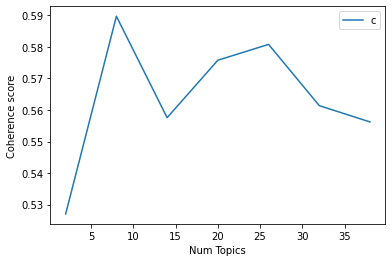

In [165]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [166]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.527
Num Topics = 8  has Coherence Value of 0.5897
Num Topics = 14  has Coherence Value of 0.5576
Num Topics = 20  has Coherence Value of 0.5758
Num Topics = 26  has Coherence Value of 0.5808
Num Topics = 32  has Coherence Value of 0.5614
Num Topics = 38  has Coherence Value of 0.5562
